In [15]:
import pylab
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

pd.options.mode.chained_assignment = None
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [7]:
df_items0 = pd.read_csv("items.csv", sep = "|")
del df_items0["campaignIndex"]
df_items0.pharmForm = df_items0.pharmForm.str.upper()
df_items0.head()

,pid,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,rrp
0,1,1,2FOI,80,ST,TAB,0,40,NaN,10.89
1,2,1,2FOI,80,ST,TAB,0,40,NaN,10.89
2,3,1,2FOI,10,G,GLO,0,40,NaN,16.45
3,4,1,2FOI,80,ST,TAB,0,40,NaN,10.89
4,5,2,10OJ03JS,8,ST,PUL,0,40,1.0,22.53


In [10]:
def content(df):
    content = pd.DataFrame(df.content.str.split('X',2).tolist(), columns = ['x','y','z'])
    content = content.fillna('1')
    content.x = pd.to_numeric(content.x, errors='coerce')
    content.y = pd.to_numeric(content.y, errors='coerce')
    content.z = pd.to_numeric(content.z, errors='coerce')
    content['Content'] = content.x * content.y * content.z
    df1 = pd.concat([df, content], axis=1, join_axes=[df.index])
    df2 = df1.drop(["x", "y", "z", "content"], axis=1)
    return df2
def missing(df):
    print('Size of testing dataset : %d' % (df.shape[0]))
    df1 = df.dropna()
    print('Size of testing dataset DropNA : %d' % (df1.shape[0]))
    display(df.isnull().sum())

In [11]:
### Content
df_items1 = content(df_items0)
### Category
df_items1.group = df_items1.group.astype("category").cat.codes
df_items1.unit = df_items1.unit.astype("category").cat.codes
df_items1.pharmForm = df_items1.pharmForm.astype("category").cat.codes
### Filling Missing
df_items1.category = df_items1.category.fillna(value = df_items1.category.mean())
df_items1.Content = df_items1.Content.fillna(value = df_items1.Content.mean())
df_items1.pharmForm = df_items1.pharmForm.fillna(value = df_items1.pharmForm.mean())

missing(df_items1)
df_items1.head()

Size of testing dataset : 22035
Size of testing dataset DropNA : 22035


pid               0
manufacturer      0
group             0
unit              0
pharmForm         0
genericProduct    0
salesIndex        0
category          0
rrp               0
Content           0
dtype: int64

,pid,manufacturer,group,unit,pharmForm,genericProduct,salesIndex,category,rrp,Content
0,1,1,529,7,135,0,40,113.933996,10.89,80.0
1,2,1,529,7,135,0,40,113.933996,10.89,80.0
2,3,1,529,1,45,0,40,113.933996,16.45,10.0
3,4,1,529,7,135,0,40,113.933996,10.89,80.0
4,5,2,74,7,112,0,40,1.000000,22.53,8.0


In [12]:
def onehot2(df):
    df_oh = pd.DataFrame(np_utils.to_categorical(df,(max(df)+1)))
    original_dim = df_oh.shape[1]
    print('original dimension : %d' % df_oh.shape[1])
    return df_oh, original_dim

def pre_item(df):
    ### numerical
    df_num = df[column_conti]
    sc = MinMaxScaler(feature_range=(0, 1), copy=True)
    Z = pd.DataFrame(sc.fit_transform(df_num))
    Z.columns = column_conti
    ### categorical
    df_cat = df.drop(column_conti, axis=1)
    df_cat = df_cat.reset_index(drop=True, inplace=False, col_level=0, col_fill='')
    
    df1 = df_cat.join(Z, on=None, how='inner', lsuffix='', rsuffix='', sort=False)
    return df1

In [13]:
column_conti = ["category", "rrp", "Content"]
df_items2 = pre_item(df_items1)

In [16]:
m1, m1_dim = onehot2(df_items2.manufacturer)
g1, g1_dim = onehot2(df_items2.group)
u1, u1_dim = onehot2(df_items2.unit)
p1, p1_dim = onehot2(df_items2.pharmForm)
s1, s1_dim = onehot2(df_items2.salesIndex)

df_items_oh0 = pd.concat([df_items2, g1, p1, u1, m1, s1], axis=1, join_axes=[df_items1.index])
df_items_oh = df_items_oh0.drop(["manufacturer", "group", "unit", "pharmForm", "salesIndex"], axis=1)
df_items_oh.columns = [np.arange(1, (pd.DataFrame(df_items_oh).shape[1]+1), 1)]
df_items_oh.rename(columns={1: 'pid', 3: 'category', 4: 'rrp', 5: 'Content'}, inplace = True)
df_items_oh.head()

original dimension : 1068
original dimension : 533
original dimension : 8
original dimension : 183
original dimension : 54


,pid,2,category,rrp,Content,6,7,8,9,10,...,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851
0,1,0,0.276799,0.026723,0.003625,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0.276799,0.026723,0.003625,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0.276799,0.040454,0.000443,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.276799,0.026723,0.003625,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.000000,0.055470,0.000352,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def auto(df, encoding_dim):
    from keras.layers import Input, Dense
    from keras.models import Model
    from keras.callbacks import TensorBoard
    
    input_img = Input(shape=(df.shape[1],))
    encoded = Dense(2000, activation='relu')(input_img)
    encoded = Dense(1000, activation='relu')(encoded)
    encoded = Dense(500, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    decoded = Dense(500, activation='relu')(encoded)
    decoded = Dense(1000, activation='relu')(decoded)
    decoded = Dense(2000, activation='relu')(decoded)
    decoded = Dense(df.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input = input_img, output = decoded)
    autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
    history = autoencoder.fit(df, df,
                              nb_epoch = nb_epoch,
                              batch_size = 256,
                              shuffle = True,
                              validation_split = 0.2)
    
    from keras import backend as K
    target_layer = K.function(autoencoder.inputs, [autoencoder.layers[4].output])
    ## Extract output from the target hidden layer.
    target_layer_out = target_layer([df])
    df_auto = pd.DataFrame(np.array(target_layer_out[0]))
    print('encoding dimension : %d' % (df_auto.shape[1]))
    return df_auto, history

def Plot(train_value, test_value, value_is_loss_or_acc):
    f, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc = 0) 
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)  
    plt.show()

In [44]:
X = np.array(df_items_oh.drop(["pid"], axis = 1))

nb_epoch = 2
df_auto, history = auto(X, 33)
df_auto["pid"] = df_items_oh.pid
df_auto.head()

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 17628 samples, validate on 4407 samples
Epoch 1/2
17628/17628 [==============================] - 53s - loss: 0.6854 - val_loss: 0.6720

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,pid
0,1.529796,3.442372,5.807147,2.459816,0.0,2.795738,3.223870,0.0,3.253336,1.631724,...,7.327067,0.895372,5.131352,0.0,3.702710,3.266082,0.0,0.0,0.0,1
1,1.529796,3.442372,5.807147,2.459816,0.0,2.795738,3.223870,0.0,3.253336,1.631724,...,7.327067,0.895372,5.131352,0.0,3.702710,3.266082,0.0,0.0,0.0,2
2,1.344183,3.145140,5.205159,2.211222,0.0,2.551378,2.903319,0.0,2.898152,1.384478,...,6.589330,0.751761,4.624106,0.0,3.304145,2.882103,0.0,0.0,0.0,3
3,1.529796,3.442372,5.807147,2.459816,0.0,2.795738,3.223870,0.0,3.253336,1.631724,...,7.327067,0.895372,5.131352,0.0,3.702710,3.266082,0.0,0.0,0.0,4
4,1.217261,2.844074,4.865470,1.997627,0.0,2.332798,2.686045,0.0,2.705299,1.327248,...,6.073500,0.733742,4.240372,0.0,3.121097,2.737063,0.0,0.0,0.0,5


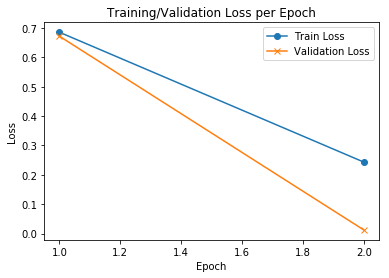

In [45]:
Plot(history.history['loss'], history.history['val_loss'], 'Loss')

# Training Dataset

In [46]:
def preprocessing(df):
    df["number"] = df["revenue"] / df["price"]
    
    click = df[(df.click == 1)]
    basket = df[(df.basket == 1)]
    order = df[(df.order == 1)]
    click["class_label"] = 0
    basket["class_label"] = 0
    order["class_label"] = 1
    df1 = pd.concat([click, basket, order])
    df1 = df1.sort(["lineID"], ascending = True)
    return df1

In [47]:
df_train0 = pd.read_csv("train.csv", sep = "|")
df_train = preprocessing(df_train0)
missing(df_train)
df_train.head()

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Size of testing dataset : 2756003
Size of testing dataset DropNA : 2655316


lineID                  0
day                     0
pid                     0
adFlag                  0
availability            0
competitorPrice    100687
click                   0
basket                  0
order                   0
price                   0
revenue                 0
number                  0
class_label             0
dtype: int64

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue,number,class_label
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.00,0.0,0
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.00,0.0,0
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.00,0.0,0
3,4,1,1145,1,1,6.59,0,0,1,6.55,6.55,1.0,1
4,5,1,3394,0,1,4.39,0,0,1,4.14,4.14,1.0,1


In [48]:
### Filling Missing Value
df_train.competitorPrice = df_train.competitorPrice.fillna(value = np.mean(df_train.competitorPrice))

In [49]:
result0 = pd.merge(df_train, df_auto, how = 'inner', on = ['pid'])
result0 = result0.sort_values(['lineID'], ascending = True)
result0.head()

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,23,24,25,26,27,28,29,30,31,32
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,0.0,6.715083,0.740837,4.716199,0.0,3.451362,2.972155,0.0,0.0,0.0
64,2,1,14922,1,1,8.57,0,1,0,8.75,...,0.0,6.715302,0.765730,4.720911,0.0,3.416727,3.032092,0.0,0.0,0.0
2397,3,1,16382,0,1,14.77,0,1,0,16.06,...,0.0,6.163531,0.672313,4.300081,0.0,3.141417,2.680362,0.0,0.0,0.0
2424,4,1,1145,1,1,6.59,0,0,1,6.55,...,0.0,5.733938,0.638887,4.018273,0.0,2.962484,2.563415,0.0,0.0,0.0
9257,5,1,3394,0,1,4.39,0,0,1,4.14,...,0.0,6.286788,0.755856,4.407227,0.0,3.208042,2.785730,0.0,0.0,0.0


## Hold Out and Training

In [50]:
##################################################### hold on last month
hold_result = result0[result0.day > 65]
hold_result = hold_result.dropna()
hold_result = hold_result.reset_index(drop = True)

result = result0[result0.day <= 65]
result = result.dropna()
result = result.reset_index(drop = True)

print('Number of hold_result: %d' % hold_result.shape[0])
print('Number of result training: %d' % result.shape[0])
print(result['class_label'].value_counts())
result.head()

Number of hold_result: 889940
Number of result training: 1866063
0    1378473
1     487590
Name: class_label, dtype: int64


,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,...,23,24,25,26,27,28,29,30,31,32
0,1,1,6570,0,2,14.60,1,0,0,16.89,...,0.0,6.715083,0.740837,4.716199,0.0,3.451362,2.972155,0.0,0.0,0.0
1,2,1,14922,1,1,8.57,0,1,0,8.75,...,0.0,6.715302,0.765730,4.720911,0.0,3.416727,3.032092,0.0,0.0,0.0
2,3,1,16382,0,1,14.77,0,1,0,16.06,...,0.0,6.163531,0.672313,4.300081,0.0,3.141417,2.680362,0.0,0.0,0.0
3,4,1,1145,1,1,6.59,0,0,1,6.55,...,0.0,5.733938,0.638887,4.018273,0.0,2.962484,2.563415,0.0,0.0,0.0
4,5,1,3394,0,1,4.39,0,0,1,4.14,...,0.0,6.286788,0.755856,4.407227,0.0,3.208042,2.785730,0.0,0.0,0.0


In [51]:
### X, Y
X = result.drop(["number", "class_label", "click", "basket", "order", "revenue"], axis=1)
Y = result[["number", "class_label"]]

In [52]:
def std(df):
    df_num = df[column_conti]
    sc = MinMaxScaler(feature_range=(0, 1), copy=True)
    Z = pd.DataFrame(sc.fit_transform(df_num))
    Z.columns = column_conti
    ################################################ reset row index
    df_cat = df.drop(column_conti, axis=1)
    df_cat = df_cat.reset_index(drop=True, inplace=False, col_level=0, col_fill='')
    
    df_std = df_cat.join(Z, on=None, how='inner', lsuffix='', rsuffix='', sort=False)
    return df_std

In [53]:
from keras.utils import np_utils
y = np_utils.to_categorical(np.array(Y[["class_label"]]), 2) 

column_conti = ["lineID","day", "pid", "competitorPrice", "price"]
df_st = std(X)
df_st.head()

,adFlag,availability,0,1,2,3,4,5,6,7,...,28,29,30,31,32,lineID,day,pid,competitorPrice,price
0,0,2,1.402600,3.185176,5.385137,2.220817,0.0,2.581421,2.935397,0.0,...,3.451362,2.972155,0.0,0.0,0.0,0.000000e+00,0.0,0.298130,0.055180,0.044533
1,1,1,1.356105,3.192947,5.372445,2.295418,0.0,2.526130,2.936643,0.0,...,3.416727,3.032092,0.0,0.0,0.0,5.358879e-07,0.0,0.677181,0.032390,0.023045
2,0,1,1.216502,2.888940,4.920254,2.007736,0.0,2.371698,2.689872,0.0,...,3.141417,2.680362,0.0,0.0,0.0,1.071776e-06,0.0,0.743442,0.055822,0.042342
3,1,1,1.145430,2.702049,4.558680,1.931830,0.0,2.202289,2.523163,0.0,...,2.962484,2.563415,0.0,0.0,0.0,1.607664e-06,0.0,0.051920,0.024906,0.017238
4,0,1,1.275748,2.958179,4.997351,2.093536,0.0,2.410991,2.828154,0.0,...,3.208042,2.785730,0.0,0.0,0.0,2.143552e-06,0.0,0.153989,0.016592,0.010876


In [54]:
def split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    print('Number of Features: %d' % X_train.shape[1])
    print('Number of training: %d' % X_train.shape[0])
    print('Number of testing: %d' % X_test.shape[0])
    a = pd.DataFrame(y_test)
    a.columns = ["a", "b"]
    print("===testing dataset label===")
    print(a['a'].value_counts())
    return X_train, X_test, y_train, y_test

In [55]:
X_train, X_test, y_train, y_test = split(np.array(df_st), y)

Number of Features: 40
Number of training: 1492850
Number of testing: 373213
===testing dataset label===
1.0    275679
0.0     97534
Name: a, dtype: int64


In [72]:
batch_size = 128
nb_classes = 2
nb_epoch = 2

img_rows, img_cols = 5, 8
nb_filters = 32
pool_size = (2, 2)
kernel_size = (3, 3)

In [73]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [76]:
model = Sequential()

model.add(Convolution2D(nb_filters,
                        kernel_size[0],
                        kernel_size[1],
                        border_mode = 'valid',
                        input_shape = input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = pool_size, dim_ordering="th"))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
model.summary()

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(5, 8, 1), padding="valid")`
/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 3, 6, 32)          320       
_________________________________________________________________
activation_13 (Activation)   (None, 3, 6, 32)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 4, 32)          9248      
_________________________________________________________________
activation_14 (Activation)   (None, 1, 4, 32)          0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 2, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 2, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
__________

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = batch_size,  
                    epochs = nb_epoch,  
                    verbose = 1,  
                    validation_split = 0.1,  
                    class_weight = {0: 1, 1: 2.7})

loss = history.history.get('loss')
acc = history.history.get('acc')

''' Access the performance on validation data '''
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(0)
plt.subplot(121)
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(range(len(acc)), acc,label = 'Training')
plt.plot(range(len(val_acc)), val_acc,label = 'Validation')
plt.title('Accuracy')
plt.show()

Train on 1343565 samples, validate on 149285 samples
Epoch 1/2
1343565/1343565 [==============================] - 98s - loss: 0.9751 - acc: 0.6060 - val_loss: 0.9684 - val_acc: 0.5474

In [78]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.66170332662
Test accuracy: 0.600030009674
